# **Классификация аритмий на основе сверточной нейронной сети**

# **- цель проекта:**

Обучить нейронную сеть для распознавания патологической ЭКГ (электрокардиограммы) из массива данных (таблица с цифровым обозначением вольтажа)


Обрести навык работы с файлами данных ЭКГ. Повторить и расширить знания по работе со Сверточными НС.



# **- описание базы:**

**Кол-во примеров:** 109446

**Кол-во категорий:** 5

**Частота:** 125Hz

**Источник информации:** Physionet's MIT-BIH Arrhythmia Dataset

**Классы:**

'Нормальный ритм': 0, 

'Остальные нарушения ритма': 1, 

'Желудочковая экстросистола': 2, 

'Предсердная экстрасистола': 3, 

'Сливной комплекс': 4

# **Введение**

Электрокардиограафия (далее ЭКГ) — методика регистрации и исследования электрических полей, образующихся при работе сердца.

Итог ЭКГ - электрокардиограмма.

Электрокардиограмму можно представить ввиде массива содержащего данные о вольтаже (мВ) в момент времени.

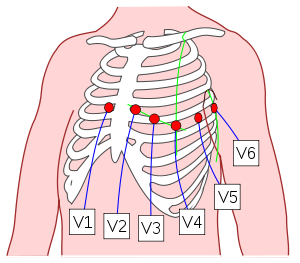

# **Подгружаем библиотеки**

In [ ]:
import os
import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ЭКГ-ДИПЛОМ/mitbih_train.csv", header = None)
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ЭКГ-ДИПЛОМ/mitbih_test.csv", header = None)

In [ ]:
train_df.shape

(87554, 188)

In [ ]:
test_df.shape

(21892, 188)

In [ ]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [ ]:
test_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


# **Уравняем классы**

In [ ]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


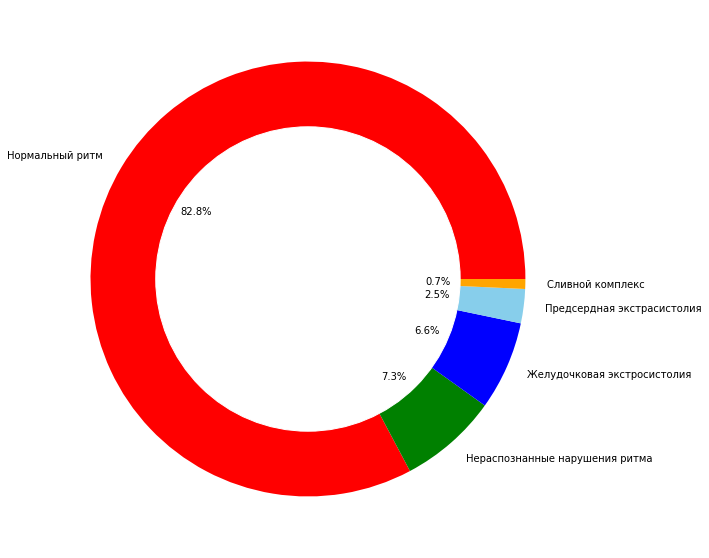

In [ ]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['Нормальный ритм','Нераспознанные нарушения ритма',
                           'Желудочковая экстросистолия','Предсердная экстрасистолия',
                           'Сливной комплекс'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [ ]:
df_23764527364 = pd.DataFrame([['Earth', 1], ['Moon', 0.606], ['Mars', 0.107]])
df_23764527364

,0,1
0,Earth,1.000
1,Moon,0.606
2,Mars,0.107


In [ ]:
df_23764527364_upsample=resample(df_23764527364,replace=True,n_samples=10,random_state=123)
df_23764527364_upsample

,0,1
2,Mars,0.107
1,Moon,0.606
2,Mars,0.107
2,Mars,0.107
0,Earth,1.000
2,Mars,0.107
2,Mars,0.107
1,Moon,0.606
2,Mars,0.107
1,Moon,0.606


In [ ]:
equilibre=train_df[187].value_counts()
print(equilibre)

0    20000
1    20000
2    20000
3    20000
4    20000
Name: 187, dtype: int64


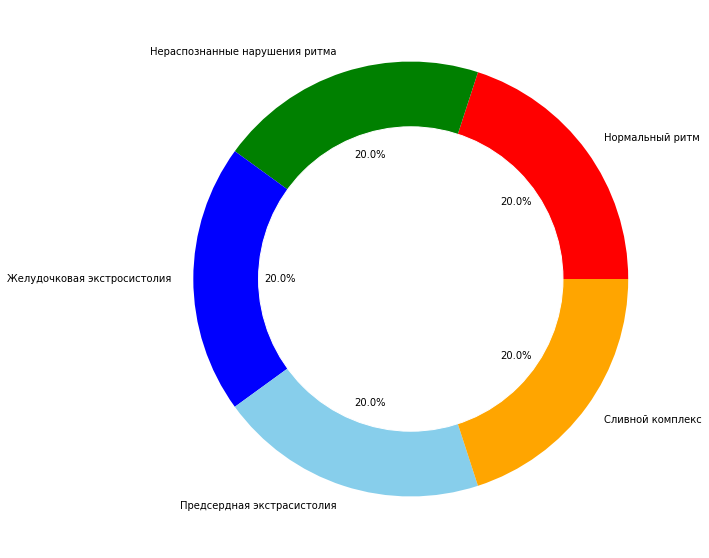

In [ ]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['Нормальный ритм','Нераспознанные нарушения ритма',
                           'Желудочковая экстросистолия','Предсердная экстрасистолия',
                           'Сливной комплекс'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# **Классы**

In [ ]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

In [ ]:
c

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
7255,1.000000,0.917778,0.780000,0.535556,0.288889,0.124444,0.108889,0.048889,0.048889,0.011111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
74309,0.893238,1.000000,0.551601,0.129893,0.048043,0.016014,0.000000,0.012456,0.042705,0.154804,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
80446,0.857860,0.750836,0.419732,0.232441,0.195652,0.182274,0.167224,0.157191,0.150502,0.135452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80777,1.000000,0.831547,0.500766,0.189893,0.000000,0.065850,0.134763,0.104135,0.078101,0.071975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
83104,0.900739,0.826822,0.756072,0.653643,0.537487,0.388596,0.242872,0.135164,0.078142,0.068638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [ ]:
def plot_hist(class_number,size,min_,bins):
    img=train_df.loc[train_df[187]==class_number].values
    img=img[:,min_:size]
    img_flatten=img.flatten()

    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(bins,bins),cmap=plt.cm.jet)
    plt.show()

# **'Нормальный ритм': 0**

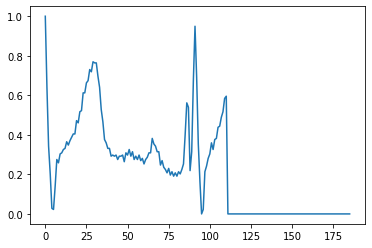

In [ ]:
 plt.plot(c.iloc[0,:186])

1300000
1300000


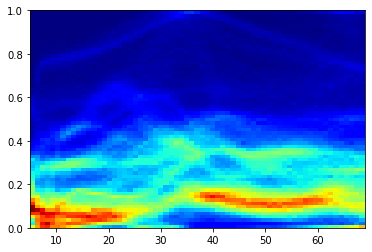

In [ ]:
plot_hist(0,70,5,65)

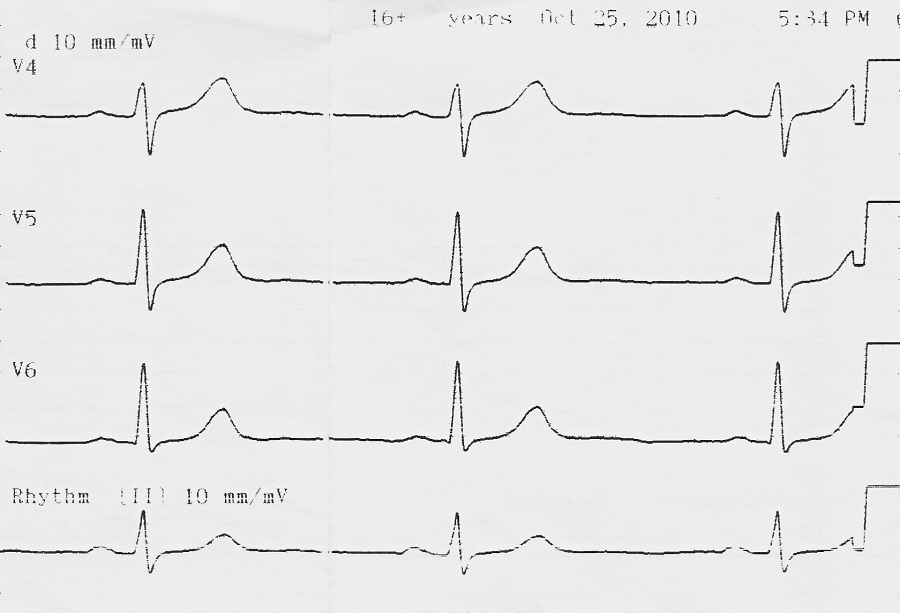


# **'Остальные нарушения ритма': 1**

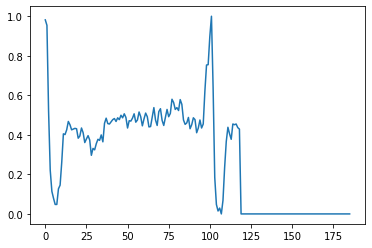

In [ ]:
 plt.plot(c.iloc[1,:186])

900000
900000


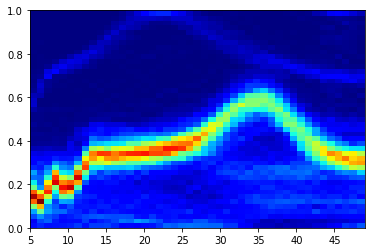

In [ ]:
plot_hist(1,50,5,45)

# **'желудочковая экстросистола': 2**

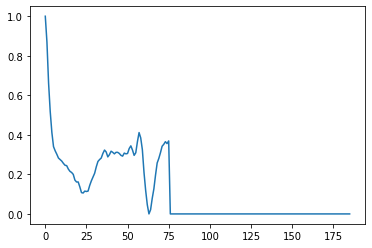

In [ ]:
 plt.plot(c.iloc[2,:186])

900000
900000


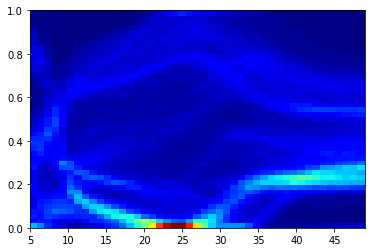

In [ ]:
plot_hist(2,50,5,45)

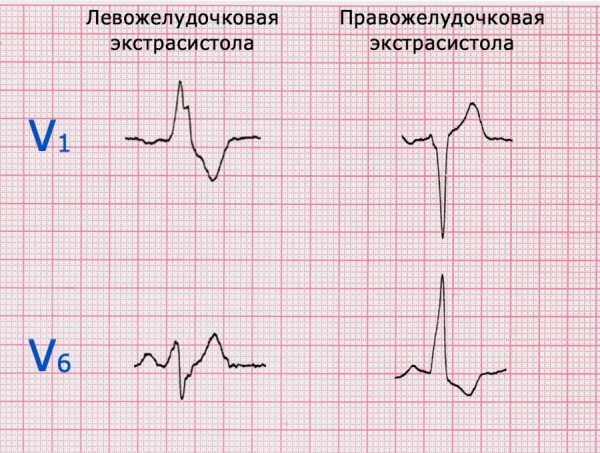

# **'Предсердная экстрасистола': 3**

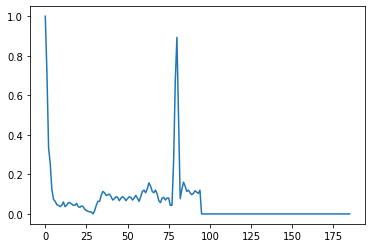

In [ ]:
plt.plot(c.iloc[3,:186])

900000
900000


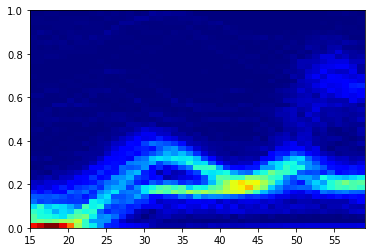

In [ ]:
plot_hist(3,60,15,45)

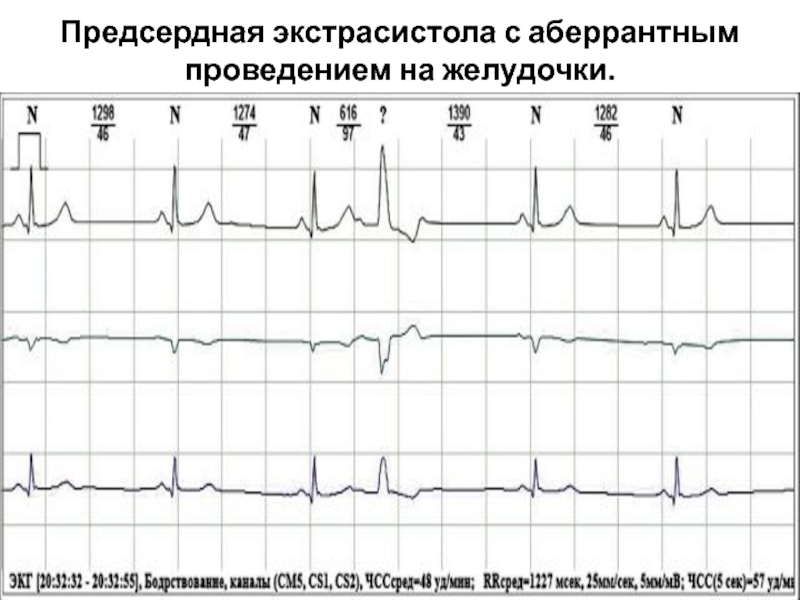

# **'Сливной комплекс': 4**

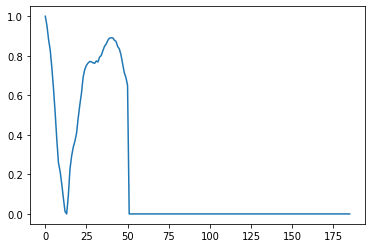

In [ ]:
plt.plot(c.iloc[4,:186])

700000
700000


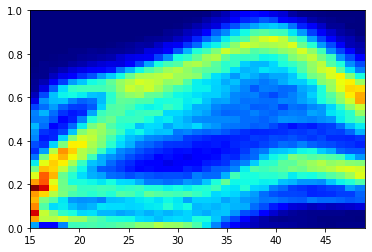

In [ ]:
plot_hist(4,50,15,35)

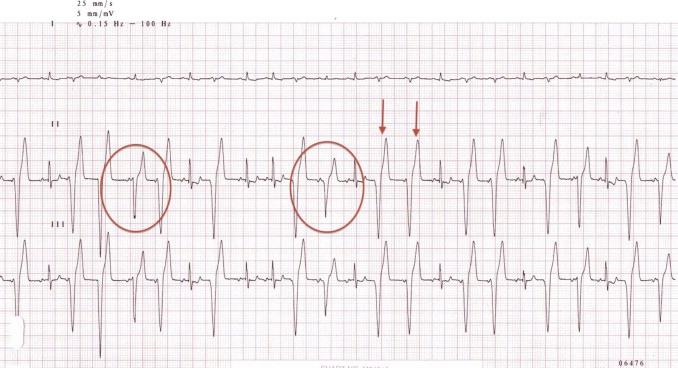

In [ ]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.5,186)
    return (signal+noise)

In [ ]:
np.random.normal(0,0.5,186)

array([ 8.37521123e-01, -5.20669013e-01, -2.52474901e-01,  7.51985812e-01,
       -2.63534033e-01, -5.44585145e-01, -5.89614318e-04,  1.13704020e-01,
       -2.37307599e-03, -2.68396735e-01,  6.48606468e-01, -2.28705214e-01,
        1.56767233e-02, -2.30399893e-01, -7.61599831e-01, -2.09183205e-01,
       -8.87189685e-01, -2.13368214e-01,  1.39492489e-01, -1.43279462e-01,
        4.50604825e-01, -4.71347626e-01,  1.91482941e-01,  1.33003779e-01,
       -2.90201429e-01, -4.52864117e-01, -3.81230048e-01,  1.40169446e-01,
       -3.76667732e-01, -2.41295112e-01, -1.03340353e-02,  4.45818818e-02,
       -7.81851900e-01,  7.20675600e-02,  2.95599944e-01,  3.30277056e-02,
       -4.78943867e-02,  3.70424267e-01,  7.96129526e-01,  4.07981713e-01,
        9.14503274e-01, -1.87210510e-01, -7.53750676e-01,  6.47145090e-01,
        3.86753440e-01,  1.81285801e-02, -4.47973326e-01, -2.46802742e-01,
       -3.87868459e-01,  2.34231079e-01, -2.11964283e-01, -1.90354955e-02,
        2.26456516e-01,  

In [ ]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [ ]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [ ]:
X_train

array([[[-0.27327084],
        [-0.17410488],
        [ 1.04228838],
        ...,
        [ 0.55807444],
        [ 0.46767089],
        [-0.32348341]],

       [[ 0.18468736],
        [ 0.53239701],
        [ 0.00719728],
        ...,
        [-0.33289675],
        [ 0.08988028],
        [-0.6266436 ]],

       [[ 0.64566068],
        [ 0.85592855],
        [-0.18255918],
        ...,
        [ 0.02224762],
        [-0.15895598],
        [-0.03156827]],

       ...,

       [[ 0.38774986],
        [ 1.26820045],
        [ 0.51145575],
        ...,
        [-0.83322675],
        [ 0.10309152],
        [ 0.5272605 ]],

       [[ 0.51639362],
        [ 1.22577015],
        [ 1.34367622],
        ...,
        [ 0.1176965 ],
        [ 0.40304861],
        [ 0.84697155]],

       [[ 0.54776722],
        [ 0.84887295],
        [ 0.2734088 ],
        ...,
        [-0.372528  ],
        [ 1.08387254],
        [-0.30898843]]])

In [ ]:
X_train.shape

(100000, 186, 1)

# **Тестовая сеть**

In [ ]:
def test_network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (16), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)

    conv2_1=Convolution1D(64, (8), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)

    conv3_1=Convolution1D(64, (8), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)

    dense_end1 = Dense(128, activation='relu')(flatten)
    dense_end2 = Dense(64, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer=optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    #callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             #ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/ЭКГ-ДИПЛОМ/best_weight/best_model.h5',
                             #monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=15, batch_size=32,validation_data=(X_test,y_test))
    model.save_weights('/content/drive/MyDrive/Colab Notebooks/ЭКГ-ДИПЛОМ/best_weight/best_model.h5')
    model.load_weights('/content/drive/MyDrive/Colab Notebooks/ЭКГ-ДИПЛОМ/best_weight/best_model.h5')
    return(model,history)

In [ ]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Эпохи')
    plt.ylabel('Точность')
    plt.title('Точность модели')
    plt.legend(['Тренировочная', 'Проверочная'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Эпохи')
    plt.ylabel('Ошибка')
    plt.title('Ошибка модели')
    plt.legend(['Тренировочная', 'проверочная'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [ ]:
model,history=test_network(X_train,y_train,X_test,y_test)

Epoch 1/15
3125/3125 [==============================] - 28s 6ms/step - loss: 0.8899 - accuracy: 0.6596 - val_loss: 0.6523 - val_accuracy: 0.8050
Epoch 2/15
3125/3125 [==============================] - 19s 6ms/step - loss: 0.7836 - accuracy: 0.7017 - val_loss: 1.0821 - val_accuracy: 0.7569
Epoch 3/15
3125/3125 [==============================] - 19s 6ms/step - loss: 0.7480 - accuracy: 0.7156 - val_loss: 0.8372 - val_accuracy: 0.7963
Epoch 4/15
3125/3125 [==============================] - 17s 5ms/step - loss: 0.7175 - accuracy: 0.7272 - val_loss: 0.7969 - val_accuracy: 0.7008
Epoch 5/15
3125/3125 [==============================] - 18s 6ms/step - loss: 0.6847 - accuracy: 0.7394 - val_loss: 0.9670 - val_accuracy: 0.6454
Epoch 6/15
3125/3125 [==============================] - 18s 6ms/step - loss: 0.6456 - accuracy: 0.7533 - val_loss: 0.8772 - val_accuracy: 0.6843
Epoch 7/15
3125/3125 [==============================] - 17s 6ms/step - loss: 0.6063 - accuracy: 0.7684 - val_loss: 0.9319 - val_ac

Accuracy: 44.08%


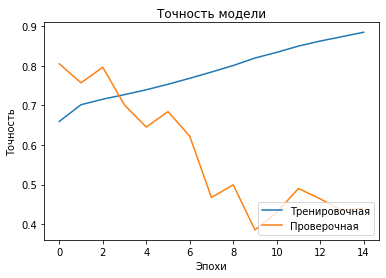

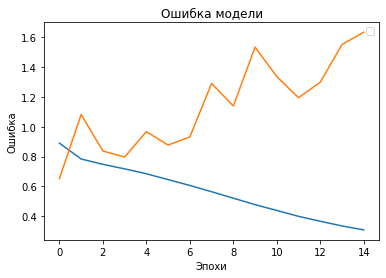

685/685 [==============================] - 1s 2ms/step


In [ ]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Матрица корреляций (с нормализацией)")
    else:
        print('Матрица корреляций, без нормализации')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Реальное значение')
    plt.xlabel('Прогноз')

cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Матрица с нормализацией')
plt.show()
print("------------------------------")
print("------------------------------")
print("Нормальный ритм: N, Остальные нарушения ритма: S, Желудочечная экстросистола: V, Предсердная экстрасистола: F, Сливной комплекс': Q")

____________________________________________________

____________________________________________________

____________________________________________________

____________________________________________________

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
def network_2(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)

    conv1_1 = Dense(64, activation="relu")(conv1_1)
    conv1_1 = BatchNormalization()(conv1_1)


    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)


    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)

    conv2_1 = Dense(64, activation="relu")(conv2_1)
    conv2_1 = BatchNormalization()(conv2_1)


    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)


    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)

    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)

    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics = ['accuracy'])
    

    history=model.fit(X_train, y_train,epochs=14, batch_size=32,validation_data=(X_test,y_test))
    model.save_weights('/content/drive/MyDrive/Colab Notebooks/ЭКГ-ДИПЛОМ/best_weight/best_model.h5')
    model.load_weights('/content/drive/MyDrive/Colab Notebooks/ЭКГ-ДИПЛОМ/best_weight/best_model.h5')
    return(model,history)

In [ ]:
model,history=network_2(X_train,y_train,X_test,y_test)

Epoch 1/14
3125/3125 [==============================] - 22s 7ms/step - loss: 0.9654 - accuracy: 0.6244 - val_loss: 0.9937 - val_accuracy: 0.6689
Epoch 2/14
3125/3125 [==============================] - 20s 6ms/step - loss: 0.8352 - accuracy: 0.6814 - val_loss: 1.0415 - val_accuracy: 0.6102
Epoch 3/14
3125/3125 [==============================] - 22s 7ms/step - loss: 0.7965 - accuracy: 0.6960 - val_loss: 0.9262 - val_accuracy: 0.6825
Epoch 4/14
3125/3125 [==============================] - 21s 7ms/step - loss: 0.7668 - accuracy: 0.7089 - val_loss: 1.0083 - val_accuracy: 0.6152
Epoch 5/14
3125/3125 [==============================] - 20s 6ms/step - loss: 0.7422 - accuracy: 0.7186 - val_loss: 0.9251 - val_accuracy: 0.6673
Epoch 6/14
3125/3125 [==============================] - 20s 6ms/step - loss: 0.7205 - accuracy: 0.7265 - val_loss: 0.9919 - val_accuracy: 0.6451
Epoch 7/14
3125/3125 [==============================] - 20s 6ms/step - loss: 0.6998 - accuracy: 0.7357 - val_loss: 0.9574 - val_ac

Accuracy: 76.87%


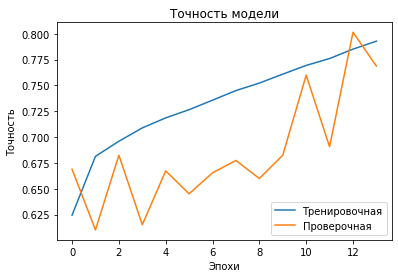

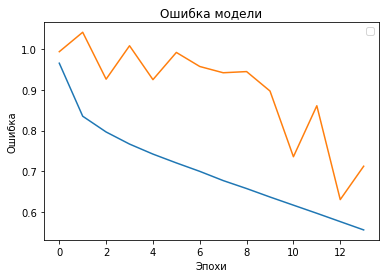

685/685 [==============================] - 3s 4ms/step


In [ ]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

Матрица корреляций (с нормализацией)


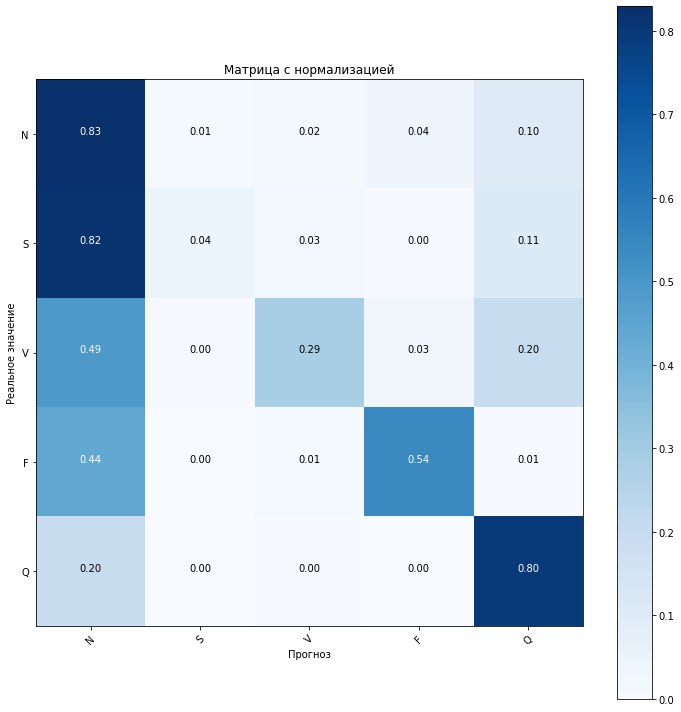

------------------------------
------------------------------
Нормальный ритм: N, Остальные нарушения ритма: S, Желудочечная экстросистола: V, Предсердная экстрасистола: F, Сливной комплекс': Q


In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Матрица корреляций (с нормализацией)")
    else:
        print('Матрица корреляций, без нормализации')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Реальное значение')
    plt.xlabel('Прогноз')

cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Матрица с нормализацией')
plt.show()
print("------------------------------")
print("------------------------------")
print("Нормальный ритм: N, Остальные нарушения ритма: S, Желудочечная экстросистола: V, Предсердная экстрасистола: F, Сливной комплекс': Q")

______________________________________________________________________________________

______________________________________________________________________________________

______________________________________________________________________________________

______________________________________________________________________________________

# **Финальная версия нейросети**

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0045)

In [ ]:
def network_1(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (32), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)

    conv1_1 = Dense(64, activation="relu")(conv1_1)
    conv1_1 = BatchNormalization()(conv1_1)


    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)


    conv2_1=Convolution1D(64, (16), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)

    conv2_1 = Dense(64, activation="relu")(conv2_1)
    conv2_1 = BatchNormalization()(conv2_1)


    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)


    conv3_1=Convolution1D(64, (16), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)

    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)

    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics = ['accuracy'])
    

    history=model.fit(X_train, y_train,epochs=10, batch_size=32,validation_data=(X_test,y_test))
    model.save_weights('/content/drive/MyDrive/Colab Notebooks/ЭКГ-ДИПЛОМ/best_weight/best_model.h5')
    model.load_weights('/content/drive/MyDrive/Colab Notebooks/ЭКГ-ДИПЛОМ/best_weight/best_model.h5')
    return(model,history)

In [ ]:
model,history=network_1(X_train,y_train,X_test,y_test)

Epoch 1/10
3125/3125 [==============================] - 26s 8ms/step - loss: 0.9806 - accuracy: 0.6188 - val_loss: 3.0060 - val_accuracy: 0.3913
Epoch 2/10
3125/3125 [==============================] - 24s 8ms/step - loss: 0.8439 - accuracy: 0.6801 - val_loss: 1.1463 - val_accuracy: 0.5887
Epoch 3/10
3125/3125 [==============================] - 24s 8ms/step - loss: 0.8123 - accuracy: 0.6928 - val_loss: 0.8436 - val_accuracy: 0.7119
Epoch 4/10
3125/3125 [==============================] - 24s 8ms/step - loss: 0.7894 - accuracy: 0.7025 - val_loss: 0.7703 - val_accuracy: 0.7282
Epoch 5/10
3125/3125 [==============================] - 24s 8ms/step - loss: 0.7717 - accuracy: 0.7099 - val_loss: 0.8131 - val_accuracy: 0.7091
Epoch 6/10
3125/3125 [==============================] - 27s 8ms/step - loss: 0.7531 - accuracy: 0.7164 - val_loss: 0.7412 - val_accuracy: 0.7147
Epoch 7/10
3125/3125 [==============================] - 24s 8ms/step - loss: 0.7378 - accuracy: 0.7231 - val_loss: 0.8053 - val_ac

Accuracy: 75.12%


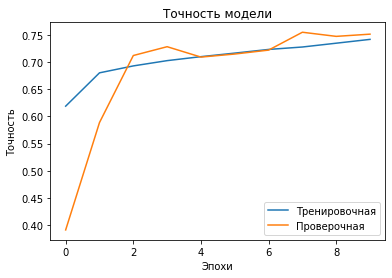

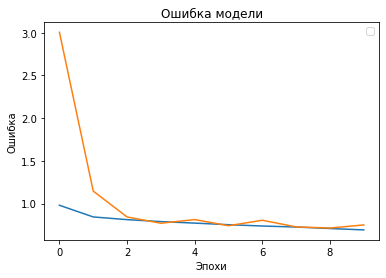

685/685 [==============================] - 3s 4ms/step


In [ ]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

Матрица корреляций (с нормализацией)


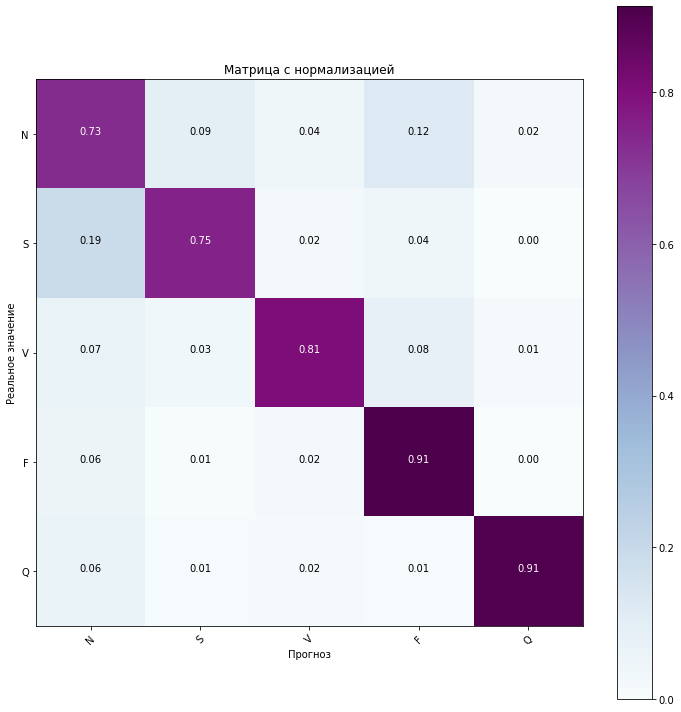

------------------------------
------------------------------
Нормальный ритм: N, Остальные нарушения ритма: S, Желудочечная экстросистола: V, Предсердная экстрасистола: F, Сливной комплекс': Q


In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Матрица корреляций (с нормализацией)")
    else:
        print('Матрица корреляций, без нормализации')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Реальное значение')
    plt.xlabel('Прогноз')

cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Матрица с нормализацией')
plt.show()
print("------------------------------")
print("------------------------------")
print("Нормальный ритм: N, Остальные нарушения ритма: S, Желудочечная экстросистола: V, Предсердная экстрасистола: F, Сливной комплекс': Q")

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/ЭКГ-ДИПЛОМ/best_best_model")

# **Вывод.**

Нормальный ритм: N - точность (на проверочной выборке) 69 %,

 Остальные нарушения ритма: S - точность 76 %,
 
Желудочковая экстросистола: V - точность 71 %,

**Предсердная экстрасистола: F - точность 93 %,**
 
**Сливной комплекс': Q - точность 93 %.**


Модель склонна к переобучению. 20-50-100 эпох дают только повышение ошибки (уменьшение точности). Оптимальным вариантом оказалось минимальное кол-во эпох (до 20). Добавление шумов дало прирост точности. Подобран оптимальный вариант шага обучения и кол-ва эпох.


**Причины:** Из-за неравномерной базы потребовалось провести resample, что привело к появлению копий, аугминтация (добавление Гаусовского шума) слегка улучшила ситуацию. 